In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from MARBLE import plotting, utils, geometry, net

# Create functions on the cone

In [2]:
def f1(x):
    return np.cos(x[:,[0]]) + np.sin(x[:,[1]])

def f2(x):
    return np.cos(x[:,[0]]) + np.sin(2*x[:,[1]])

def sample_cone(alpha, nr, ntheta):
    r = np.sqrt(np.linspace(0.5, 5, nr))
    theta = np.linspace(0, 2*np.pi, ntheta)
    r, theta = np.meshgrid(r, theta)
    X = r*np.cos(theta)
    Y = r*np.sin(theta)
    Z = -(alpha*r)**2
    
    return np.column_stack([X.flatten(), Y.flatten(), Z.flatten()])

# Continuously deform the manifold

In [55]:
n_steps = 4
alpha = np.linspace(0, 0.5, n_steps)
nr = 100
ntheta = 400

x_ = np.linspace(-np.pi, np.pi, nr)
y_ = np.linspace(-np.pi, np.pi, ntheta)
x_, y_ = np.meshgrid(x_, y_)
X = np.column_stack([x_.flatten(), y_.flatten()])
    
y = [f1(X) for i in range(n_steps)] + [f2(X) for i in range(n_steps)]
x = 2 * [sample_cone(a, nr, ntheta) for a in alpha]

# Subsample

In [56]:
ind, _ = geometry.furthest_point_sampling(x[0], stop_crit=0.025)
x = [x_[ind] for x_ in x]
y = [y_[ind] for y_ in y]

In [57]:
k = 10
data = utils.construct_dataset(x, y, graph_type='cknn', k=k)

/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


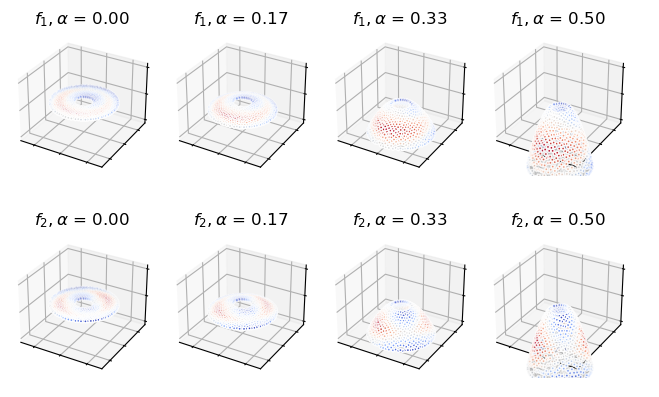

In [58]:
titles = [r'$f_1,\alpha$ = {:0.2f}'.format(a) for a in alpha] + \
        [r'$f_2,\alpha$ = {:0.2f}'.format(a) for a in alpha]

plotting.fields(data, titles=titles, col=4, node_size=5, figsize=(8,5))#, save='scalar_fields.svg')

# Train model

In [59]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

par = {'batch_size': 256, #batch size, this should be as large as possible
       'epochs': 30, #optimisation epochs
       'order': 2, #order of derivatives
       'n_lin_layers': 2,
       'hidden_channels': 16, #number of internal dimensions in MLP
       'out_channels': 3,
       'inner_product_features': True,
       'vector' : False,
       'diffusion': False,
       'pretrained' : False
      }

model = net(data, **par)
model.run_training(data)

---- Settings: 

batch_size : 256
epochs : 30
order : 2
n_lin_layers : 2
hidden_channels : 16
out_channels : 3
inner_product_features : True
vector : False
diffusion : False
pretrained : False
lr : 0.01
frac_geodesic_nb : 2.0
frac_sampled_nb : -1
var_explained : 0.9
dropout : 0.0
bias : True
vec_norm : False
batch_norm : None
seed : 0
signal_dim : 1
emb_dim : 3
n_geodesic_nb : 20
n_sampled_nb : -1
dim_embedding : 3

---- Number of features to pass to the MLP:  3
---- Total number of parameters:  119
---- Treating features as scalar channels.

---- Training network ... 

Epoch: 1, Training loss: 25.5380, Validation loss: 30.5497
Epoch: 2, Training loss: 23.5290, Validation loss: 29.1123
Epoch: 3, Training loss: 23.3023, Validation loss: 28.9822
Epoch: 4, Training loss: 22.9544, Validation loss: 28.0147
Epoch: 5, Training loss: 23.0834, Validation loss: 28.9200
Epoch: 6, Training loss: 22.7333, Validation loss: 29.4631
Epoch: 7, Training loss: 23.0392, Validation loss: 29.1808
Epoch: 8, 

# Create embeddings and clusters

In [64]:
data = model.evaluate(data)

# Visualise embedding

Performed umap embedding on embedded results.


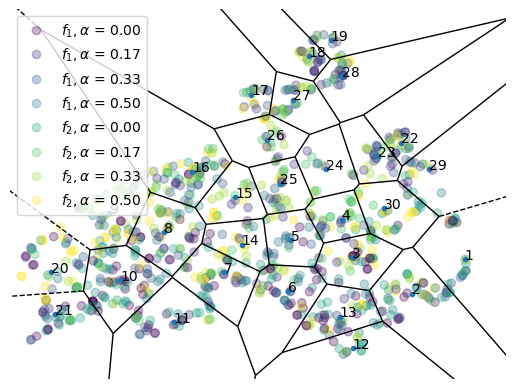

In [61]:
n_clusters = 30
emb, clusters, dist = geometry.cluster_embedding(data, n_clusters=n_clusters, embed_typ='umap')
plotting.embedding(emb, data.y.numpy(), clusters, titles=titles)#, save='scalar_fields_embedding.svg') 

Performed MDS embedding on embedded results.


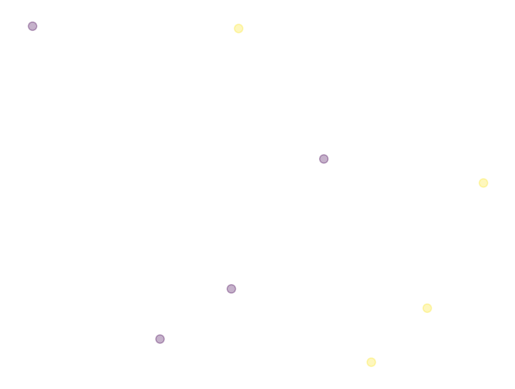

In [62]:
dist = geometry.compute_distribution_distances(data)
emb_MDS = geometry.embed(dist, embed_typ='MDS')
labels = np.array([0]*n_steps + [1]*n_steps)
plotting.embedding(emb_MDS, labels)#, save='scalar_fields_MDS.svg') 

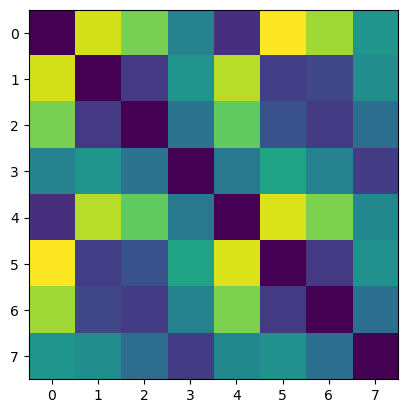

In [63]:
plt.imshow(dist)

# Plot histograms

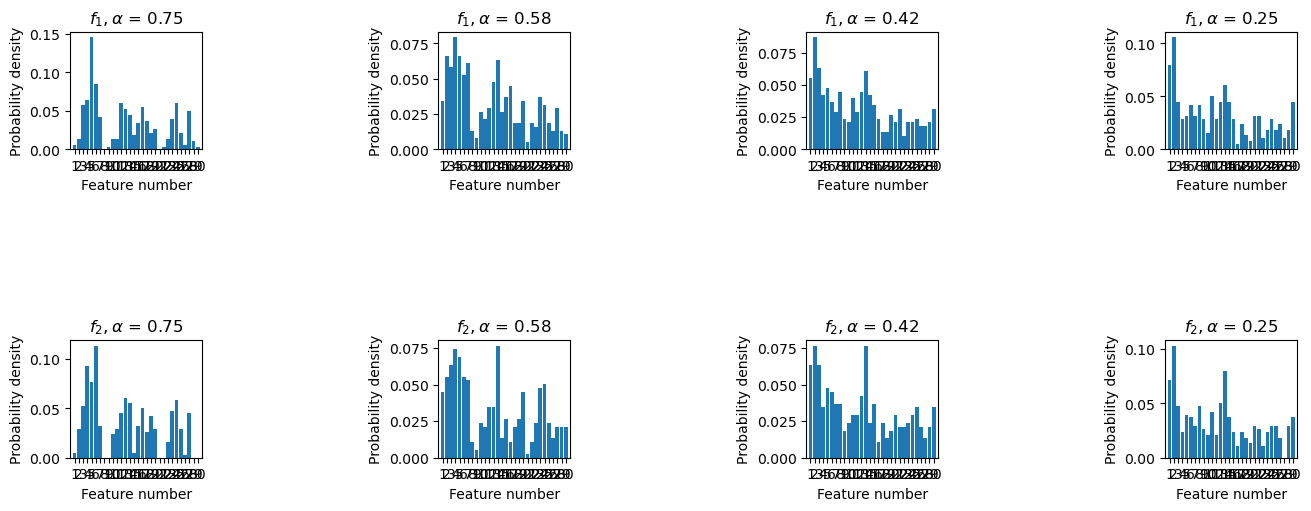

In [37]:
plotting.histograms(clusters, col=4, figsize=(13,5), titles=titles)#, save='scalar_fields_histogram.svg')

In [ ]:
plotting.neighbourhoods(data, clusters, hops=1, norm=True, )#, save='scalar_fields_nhoods.svg')